# Actividad 5

| Nombre  | <center>Triplet Loss</center> | <center>Focal Loss</center> |
|----|:----------:|---|
| ¿Cómo funciona?  | <center>La idea principal es definir una función de pérdida que induzca el aprendizaje de un embedding de objetos tal que si yo tomo un objeto de referencia _anchor_ y lo comparo con un objeto similar _positive_ y con otro objeto menos similar _negative_, entonces _positive_ debería estar más cerca de _anchor_ que _negative_ en el espacio de embedding, de acuerdo a algún tipo de métrica de distancia </center> | <center>La idea es darle mayor peso a los ejemplos de entrenamiento más difíciles y menos peso a los ejemplos más fáciles, con el fin de contrarrestar el desbalance en la contribución de ejemplos fáciles (mayoría) y difíciles (minoría) a la función de pérdida </center> |
| ¿Qué parámetros tiene y para qué sirven?  | <center>La triplet loss se suele implementar como una _Triplet Margin Loss_:</center> <br> $$loss(a,p,n) = max\{0, m + D(f(a),f(p)) - D(f(a),f(n))\}$$ <br> <center>donde $a$, $p$ y $n$ son _anchor_, _positive_ y _negative_ respectivamente, $f$ es la función de embedding, $D$ es la métrica de distancia y $m$ es un **margin**. La idea del margin es asegurar que $n$ esté a lo menos $m$ unidades más lejos de $a$ que $p$. </center> | <center>La Focal Loss está definida por la siguiente fórmula:</center> <br> $$ \text{FL}(p_t) = -(1-p_t)^\lambda \text{log}(p_t) $$ <br> <center>donde $p_t$ es la probabilidad de que nuestro modelo produzca la respuesta correcta en el ejemplo $t$ (donde el ideal es lograr $p_t = 1$) y $\lambda$ es un hiperparámetro que controla la itensidad del ponerador $(1-p_t)$. Notar que este ponderador es más grande para los ejemplos más difíciles (donde $p_t$ es más cercano a 0). </center>|
| ¿En qué tareas se puede usar?  | Se puede usar en tareas donde se quiere aprender una función que mapee objetos a vectores en un espacio de embedding tal que los objetos queden cerca/lejos entre sí en concordancia a algún criterio del mundo real. Por ejemplo, en la tarea de reconocimiento de caras, uno quiere que una foto de una cara quede más cerca a otra foto de la misma cara que la foto de una cara de otra persona. Otro caso de uso es _similar image retrieval_, donde la query es una imagen y quiero una lista de imágenes similares rankeadas por similaridad.  | En teoría se puede usar en cualquier problema donde exista un gran desbalance entre ejemplos fáciles y difíciles, y en donde la predicción del modelo se pueda expresar en forma de una probabilidad (entre 0 y 1). En el paper original por ej. lo usan para el problema de SSD (single shot detection) donde muchas bounding boxes se clasifican como background (casos fáciles) y pocas bounding boxes recaen sobre objetos (casos difíciles). |

# Actividad 6

In [5]:
from torch.utils.data import Dataset, DataLoader
from torch import nn as nn
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import optim
from torch.nn.functional import logsigmoid
import torchvision
import torch
import os
import math
import random
import time
import copy
from PIL import Image

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class TripletDataset(Dataset):

    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.class_names = []
        self.class_files = []
        self.transform = transform
        self.pair2acc = dict()
        
        g = os.walk(self.root_dir)
        next(g)
        for dirpath, _, files in g:
            self.class_names.append(os.path.basename(dirpath))
            self.class_files.append(list(os.path.join(dirpath, f) for f in files))
    
    def reset_accuracies(self):
        self.pair2acc.clear()
        
    def track_accuracies(self, idxs, correctly_ranked):        
        assert len(idxs) == len(correctly_ranked)
        for idx, c in zip(idxs, correctly_ranked):
            t = self.triplets[idx]
            p = (t[0][0], t[2][0])
            try:
                acc = self.pair2acc[p]                
            except KeyError:
                acc = self.pair2acc[p] = [0, 0]
            if (c): acc[0] += 1
            acc[1] += 1
        
    def validate_triplets(self):
        for t in self.triplets:
            assert len(t) == 3
            assert t[0][0] == t[1][0]
            assert t[0][1] != t[1][1]
            assert t[0][0] != t[2][0]
        print('triplets successfully validated!')
        
    def randomly_generate_triplet_dataset(self, n_triplets, top_k_hard=100, hard_threshold=0.25):
        since = time.time()        
        self.triplets = []
        p2acc = self.pair2acc
        
        if len(p2acc) > 0:
            print('sampling hard triplets first ...')
            n_hard_triplets = math.ceil(hard_threshold * n_triplets)
            pairs = list(p2acc.keys())
            pairs.sort(key=lambda p: (p2acc[p][0] / p2acc[p][1], -p2acc[p][1]))
            pairs = pairs[:top_k_hard]
            # print([(p,p2acc[p][0] / p2acc[p][1],p2acc[p]) for p in pairs]) # DEBUGGING
            n_triplets_per_pair = math.ceil(n_hard_triplets / len(pairs))
            for pc, nc in pairs:
                iters = n_triplets_per_pair
                pm = len(self.class_files[pc])
                nm = len(self.class_files[nc])
                while iters > 0:
                    i = random.randint(0, pm-1)
                    j = random.randint(0, pm-1)
                    if (i == j):
                        continue
                    k = random.randint(0, nm-1)
                    anc = (pc,i)
                    pos = (pc,j)
                    neg = (nc,k)
                    self.triplets.append((anc,pos,neg))
                    iters -= 1
            n_triplets -= n_hard_triplets
        
        print('sampling from all classes ...')
        n_classes = len(self.class_names)
        n_triplets_per_class = math.ceil(n_triplets / n_classes)
        for c in range(n_classes):
            m = len(self.class_files[c])
            iters = n_triplets_per_class
            while iters > 0:
                i = random.randint(0, m-1)
                j = random.randint(0, m-1)
                if i == j:
                    continue
                nc = random.randint(0, n_classes-1)
                if nc == c:
                    continue
                nk = random.randint(0, len(self.class_files[nc])-1)
                anc = (c,i)
                pos = (c,j)
                neg = (nc, nk)
                self.triplets.append((anc,pos,neg))
                iters -= 1

        self.validate_triplets()
        
        elapsed_time = time.time() - since
        print('%d triplets sampled in %.2f seconds!' % (len(self.triplets), elapsed_time))

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        t = self.triplets[idx]
        aimg = pil_loader(self.class_files[t[0][0]][t[0][1]])
        pimg = pil_loader(self.class_files[t[1][0]][t[1][1]])
        nimg = pil_loader(self.class_files[t[2][0]][t[2][1]])
        return dict(
            idx=idx,
            anchor=self.transform(aimg),
            pos=self.transform(pimg),
            neg=self.transform(nimg),
        )

In [8]:
def triplet_margin_loss_forward(anchor, pos, neg, margin):
    dist2_pos = torch.sum((anchor - pos)**2, dim=1)
    dist2_neg = torch.sum((anchor - neg)**2, dim=1)
    delta = dist2_pos - dist2_neg
    loss = torch.mean(torch.clamp(delta + margin, min=0.))
    correctly_ranked = delta < 0.
    return loss, correctly_ranked

def triplet_crossentropy_loss_forward(anchor, pos, neg):
    dist2_pos = torch.sum((anchor - pos)**2, dim=1)
    dist2_neg = torch.sum((anchor - neg)**2, dim=1)
    delta = dist2_neg - dist2_pos
    loss = -torch.mean(logsigmoid(delta))
    correctly_ranked = delta > 0.
    return loss, correctly_ranked

def train_model(model, optimizer, scheduler, history, datasets, device, num_epochs,
                n_triplets_train = 1000000,
                n_triplets_val = 10000,
                margin = 1.0,
                batch_size=64,
                best_train_acc=0.0, best_val_acc=0.0):
    
    since = time.time()    
    best_model_wts = copy.deepcopy(model.state_dict())    
    num_epochs_before = len(history['train_loss'])
    
    if margin is None:
        print("*** using triplet_crossentropy_loss")
        triplet_loss_forward = triplet_crossentropy_loss_forward
    else:
        print("*** using triplet_margin_loss")
        triplet_loss_forward = lambda *args : triplet_margin_loss_forward(*args, margin)
    
    for epoch in range(num_epochs_before, num_epochs_before + num_epochs):
        print('\n====== [Epoch {}/{}]'.format(epoch, num_epochs_before + num_epochs - 1))
        
        for phase in ('train', 'val'):
            
            print('--------------------- %s ---------------------' % phase)            
            
            if phase == 'train':
                model.train()                
                datasets['train'].randomly_generate_triplet_dataset(n_triplets_train)
                datasets['train'].reset_accuracies()
                dataloader = DataLoader(datasets['train'],
                                        shuffle=True, batch_size=batch_size, num_workers=4)
            else:
                model.eval()
                datasets['val'].randomly_generate_triplet_dataset(n_triplets_val)
                dataloader = DataLoader(datasets['val'],
                                        batch_size=batch_size, num_workers=4)

            running_loss = 0.0
            running_acc = 0
            running_count = 0
            epoch_since = time.time()
                
            with torch.set_grad_enabled(phase == 'train'):                
                
                for batch_idx, batch in enumerate(dataloader):
                    anchor = batch['anchor'].to(device)
                    pos = batch['pos'].to(device)
                    neg = batch['neg'].to(device)
                    
                    optimizer.zero_grad()                    
                    
                    # forward pass
                    x_anchor = model(anchor)
                    x_pos = model(pos)
                    x_neg = model(neg)
                    loss, correctly_ranked = triplet_loss_forward(x_anchor, x_pos, x_neg)
                    
                    # backward pass + optimization only if in training phase
                    if phase == 'train':                        
                        loss.backward()
                        optimizer.step()
                        datasets['train'].track_accuracies(batch['idx'], correctly_ranked)

                    # statistics
                    running_loss += loss.item() * anchor.size(0)
                    running_acc += torch.sum(correctly_ranked)
                    running_count += anchor.size(0)
                    
                    if (batch_idx % 20 == 0 or batch_idx + 1 == len(dataloader)):
                        print("Batch: %d/%d, running_loss=%.5f, running_acc=%.5f, elapsed_secs=%.2f" % (
                            batch_idx+1, len(dataloader),
                            running_loss/running_count,
                            running_acc.double()/running_count,
                            time.time() - epoch_since,
                        ), end="\r", flush=True)
            print()
                    
            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = float(running_acc.double() / len(datasets[phase]))
            
            history['%s_loss' % phase].append(epoch_loss)
            history['%s_acc' % phase].append(epoch_acc)
            
            if phase == 'val':
                
                scheduler.step(epoch_acc) # update learning rate if necessary
                
                if epoch_acc > best_val_acc or (
                        epoch_acc == best_val_acc and\
                        last_train_acc > best_train_acc): # improvement detected!
                    
                    # update best train and val accuracies
                    best_val_acc = epoch_acc
                    best_train_acc = last_train_acc
                    
                    # deep copy the model
                    best_model_wts = copy.deepcopy(model.state_dict())
                    
                    print('\t*** improvement detected! best_val_acc=%f, best_train_acc=%f' % (
                        best_val_acc, best_train_acc))
                                                
            else:
                last_train_acc = epoch_acc      

    print()
    elapsed_time = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        elapsed_time // 60, elapsed_time % 60))
    print('Best val acc: {:4f}'.format(best_val_acc))

    
    return dict(
        best_model_wts=best_model_wts,
        best_val_acc=best_val_acc,
        best_train_acc=best_train_acc,
    )

In [9]:
import matplotlib.pyplot as plt

def plot_train_val_curves(checkpoint_path, figsize=(10, 6)):
    checkpoint = torch.load(checkpoint_path)
    history = checkpoint['history']
    epochs = list(range(len(history['train_loss'])))
    
    plt.figure(figsize=figsize)
    
    plt.subplot(121)
    plt.title('Loss per epoch')
    plt.plot(epochs, history['train_loss'], label='train_loss')
    plt.plot(epochs, history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(122)
    plt.title('Accuracy per epoch')
    plt.plot(epochs, history['train_acc'], label='train_acc')
    plt.plot(epochs, history['val_acc'], label='val_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')    
    best_val_acc, best_val_i = max((a,i) for i,a in enumerate(history['val_acc']))
    plt.hlines(best_val_acc, 0, len(epochs), colors=('red',), linestyles='dashed',
               label='best_val_acc=%.3f, epoch=%d' % (best_val_acc, best_val_i))
    best_train_acc, best_train_i = max((a,i) for i,a in enumerate(history['train_acc']))
    plt.hlines(best_train_acc, 0, len(epochs), colors=('green',), linestyles='dashed',
               label='best_train_acc=%.3f, epoch=%d' % (best_train_acc, best_train_i))
    
    plt.legend()
    
    plt.show()

In [19]:
import matplotlib.pyplot as plt
import random
import os
import numpy as np

def visualize_k_samples_from_class(triplets, distances, class_files, k, priorize_negative=False):
    assert len(triplets) == len(distances)
    assert len(triplets) >= k
    
    if priorize_negative:
        neg_idxs = [i for i in range(len(triplets)) if distances[i][0] >= distances[i][1]]
        if len(neg_idxs) > k:
            sampled_idxs = random.sample(neg_idxs, k)
        else:
            pos_idxs = [i for i in range if distances[i][0] < distances[i][1]]
            sampled_idxs = neg_idxs
            sampled_idxs += random.sample(pos_idxs, k - len(neg_idxs))
    else:
        sampled_idxs = np.random.choice(len(triplets), size=k, replace=False)
    
    assert len(sampled_idxs) == k
    random.shuffle(sampled_idxs)
    for idx in sampled_idxs:
        t = triplets[idx]
        dpos, dneg = distances[idx]
        aimg = class_files[t[0][0]][t[0][1]]
        pimg = class_files[t[1][0]][t[1][1]]
        nimg = class_files[t[2][0]][t[2][1]]
        visualize_triplet(aimg, pimg, nimg, dpos, dneg)

def visualize_triplet(anchor_img, pos_img, neg_img, pos_dist, neg_dist):    
    image_paths = (anchor_img, pos_img, neg_img)
    face_names = [os.path.basename(os.path.dirname(path)) for path in image_paths]
    file_names = [os.path.basename(path) for path in image_paths]
    labels = (
        '%s - %s\nanchor' % (face_names[0], file_names[0]),
        '%s - %s\npositive (dist=%.4f)' % (face_names[1], file_names[1], pos_dist),
        '%s - %s\nnegative (dist=%.4f)' % (face_names[2], file_names[2], neg_dist),
    )
    plt.close()
    plt.figure(1, (16, 5))
    for i, (path, label) in enumerate(zip(image_paths, labels)):
        ax = plt.subplot(1, 3, i+1)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xlabel(label, fontsize=16)
        with open(path, 'rb') as f:
            img = plt.imread(f)
        ax.imshow(img, interpolation="nearest")
    plt.show()    


def evaluate_model(model, checkpoint_path, dataset, device, n_triplets = 4000, batch_size=64,
                   top_k=2, worst_k=2, examples_per_class=2):
    
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['best_model_state_dict'])
    model.eval()
    dataset.randomly_generate_triplet_dataset(n_triplets)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=4)
    running_acc = 0
    running_count = 0   
    
    n_classes = len(dataset.class_names)
    class_count = [0 for _ in range(n_classes)]
    class_correct = [0 for _ in range(n_classes)]
    class_triplets = [[] for _ in range(n_classes)]
    class_distances = [[] for _ in range(n_classes)]
                
    with torch.set_grad_enabled(False):                
        for batch_idx, batch in enumerate(dataloader):
            anchor = batch['anchor'].to(device)
            pos = batch['pos'].to(device)
            neg = batch['neg'].to(device)            

            # forward pass
            x_anchor = model(anchor)
            x_pos = model(pos)
            x_neg = model(neg)                    
            dist2_pos = torch.sum((x_anchor - x_pos)**2, dim=1)
            dist2_neg = torch.sum((x_anchor - x_neg)**2, dim=1)
            delta = dist2_pos - dist2_neg
            correctly_ranked = delta < 0
            
            for idx, c, d2p, d2n in zip(batch['idx'], correctly_ranked, dist2_pos, dist2_neg):
                t = dataset.triplets[idx]
                i = t[0][0]
                class_count[i] += 1
                if (c): class_correct[i] += 1
                class_triplets[i].append(t)
                class_distances[i].append((d2p, d2n))

            # statistics
            running_acc += torch.sum(correctly_ranked)
            running_count += anchor.size(0)
            print('batch %d/%d running_acc = %.4f' % (batch_idx+1, len(dataloader),
                                                      running_acc.double()/running_count),
                 end='\r', flush=True)
            
    print()
    test_acc = float(running_acc.double() / running_count)
    print('test_acc = ', test_acc)
    
    class_acc = [class_correct[c]/class_count[c] for c in range(n_classes)]
    plt.title('Test Set Accuracy Histogram\n(acc = %.4f)' % test_acc)
    plt.hist(class_acc, bins=100)
    plt.show()
    
    class_ids = list(range(n_classes))
    class_ids.sort(key=lambda c : (class_correct[c] / class_count[c]), reverse=True)
    
    if (top_k > 0):
        print('============================= TOP %d CLASSES ===============================' % top_k)
        for k in range(top_k):            
            cid = class_ids[k]
            print('[%s] %d / %d correct triplets' % (dataset.class_names[cid], class_correct[cid], class_count[cid]))
            visualize_k_samples_from_class(
                class_triplets[cid], class_distances[cid],
                dataset.class_files, examples_per_class)
    
    if (worst_k > 0):
        print('\n\n============================= WORST %d CLASSES ===============================' % worst_k)
        for k in range(1, worst_k+1):
            cid = class_ids[-k]
            print('[%s] %d / %d correct triplets' % (dataset.class_names[cid], class_correct[cid], class_count[cid]))
            visualize_k_samples_from_class(
                class_triplets[cid], class_distances[cid],
                dataset.class_files, examples_per_class, priorize_negative=True)
    

In [16]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.97, 1.03)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './vggface2_dataset100/'
triplet_datasets = {x: TripletDataset(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}

In [12]:
model = torchvision.models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 100)
model = model.to(device)
optimizer = optim.Adam(model.parameters())

In [13]:
checkpoint_path = './model_triplet.pth'
try:
    checkpoint = torch.load(checkpoint_path)
    history = checkpoint['history']
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    best_val_acc = checkpoint['best_val_acc']
    best_train_acc = checkpoint['best_train_acc']
    print('model successfully loaded from checkpoint!')
    print('\tbest_val_acc = ', best_val_acc)
    print('\tbest_train_acc = ', best_train_acc)
    print('\tepochs already trained = ', len(history['train_loss']))
except FileNotFoundError:
    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
    best_val_acc = 0.0
    best_train_acc = 0.0

model successfully loaded from checkpoint!
	best_val_acc =  0.89775
	best_train_acc =  0.95725
	epochs already trained =  73


In [10]:
# ---- OPTIONAL: override optimizer's learning rate by setting it to a different value
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-4

In [11]:
# ---- OPTIONAL: start training from best weights instead
model.load_state_dict(checkpoint['best_model_state_dict'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [12]:
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=2, verbose=True)

In [16]:
result = train_model(model, optimizer, scheduler, history, triplet_datasets, device,
                     num_epochs = 10, n_triplets_train=20000, n_triplets_val=4000,
                     margin=1.0, batch_size = 32,
                     best_train_acc=best_train_acc, best_val_acc=best_val_acc)

*** using triplet_margin_loss

====== [Epoch 63/72]
--------------------- train ---------------------
sampling from all classes ...
triplets successfully validated!
20000 triplets sampled in 0.07 seconds!
Batch: 625/625, running_loss=0.09587, running_acc=0.96230, elapsed_secs=320.87
--------------------- val ---------------------
sampling from all classes ...
triplets successfully validated!
4000 triplets sampled in 0.04 seconds!
Batch: 125/125, running_loss=0.26365, running_acc=0.89200, elapsed_secs=20.75

====== [Epoch 64/72]
--------------------- train ---------------------
sampling hard triplets first ...
sampling from all classes ...
triplets successfully validated!
20000 triplets sampled in 0.07 seconds!
Batch: 625/625, running_loss=0.14345, running_acc=0.94235, elapsed_secs=321.33
--------------------- val ---------------------
sampling from all classes ...
triplets successfully validated!
4000 triplets sampled in 0.01 seconds!
Batch: 125/125, running_loss=0.28041, running_acc=0

In [17]:
checkpoint = dict(
    best_model_state_dict = result['best_model_wts'],
    best_val_acc = result['best_val_acc'],
    best_train_acc = result['best_train_acc'],
    history = history,
    model_state_dict = model.state_dict(),
    optimizer_state_dict = optimizer.state_dict(),
)
torch.save(checkpoint, checkpoint_path)

In [18]:
!ls -lh ./model_sigmoid.pth

-rw-rw-r-- 1 pamessina pamessina 366M May 20 16:01 ./model_sigmoid.pth


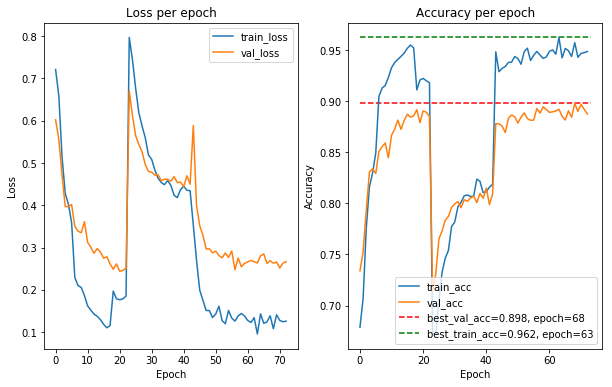

In [10]:
plot_train_val_curves(checkpoint_path)

Arriba están las curvas de loss por epoch y accuracy por epoch para entrenamiento y validación, luego de haber entrenado el modelo por más de 70 épocas. Podemos observar que la mayor accuracy alcanzada en el set de entrenamiento fue 96.2% en la época 63, mientras que la máxima accuracy en validación fue de 89.8% en la época 68. La gran caída entre las épocas 22 - 42 aprox. se debe a que me puse a experimentar con un método de sampleo diferente (en lugar de samplear triplets uniformemente, empecé a registrar las combinaciones de clases anchor-negative donde el modelo tenía menor precisión, y en el siguiente epoch sampleaba un x% de las 100 combinaciones más problemáticas y un (100 - x)% uniforme de manera normal). Como me empezó a ir mal al final bajé el porcentaje a x = 25% y volví a entrenar pero partiendo desde los mejores pesos (eso explica por qué en la época 42~ vuelvo de golpe a tener buena performance). Como después de la época 72 me dí cuenta que el modelo ya no estaba mejorando, decidí detener el entrenamiento.

sampling from all classes ...
triplets successfully validated!
10000 triplets sampled in 0.03 seconds!
batch 157/157 running_acc = 0.8840
test_acc =  0.884


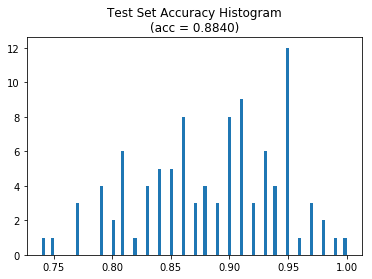

============================= TOP 2 CLASSES ===============================
[Cho_Kyuhyun] 100 / 100 correct triplets


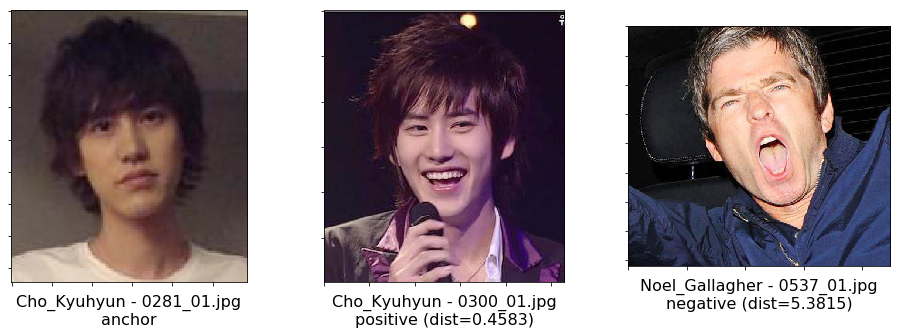

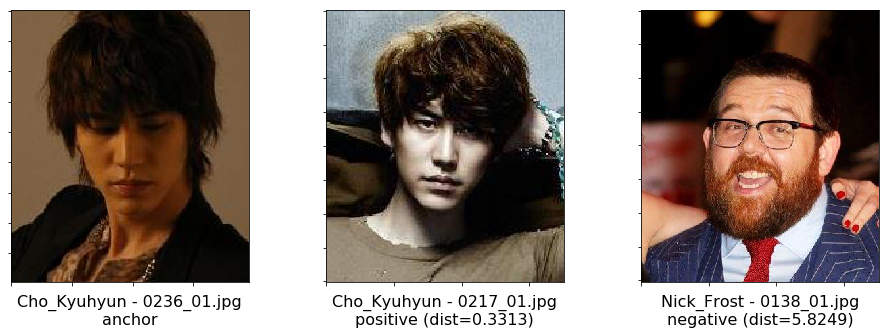

[Radoslaw_Sikorski] 99 / 100 correct triplets


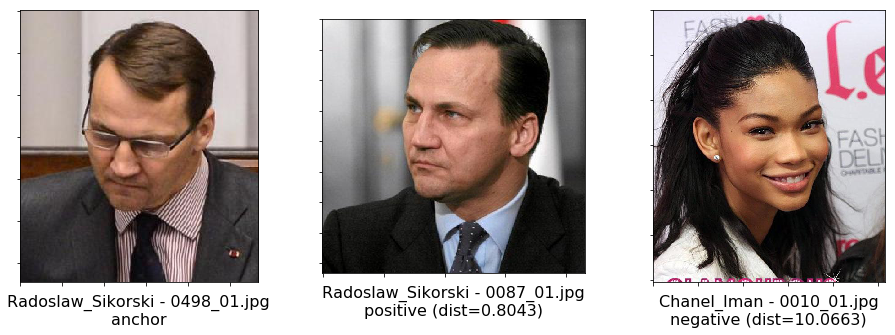

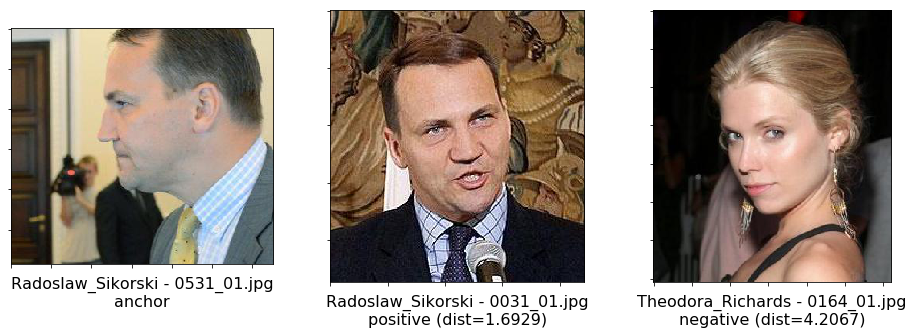



============================= WORST 2 CLASSES ===============================
[Ashley_Olsen] 74 / 100 correct triplets


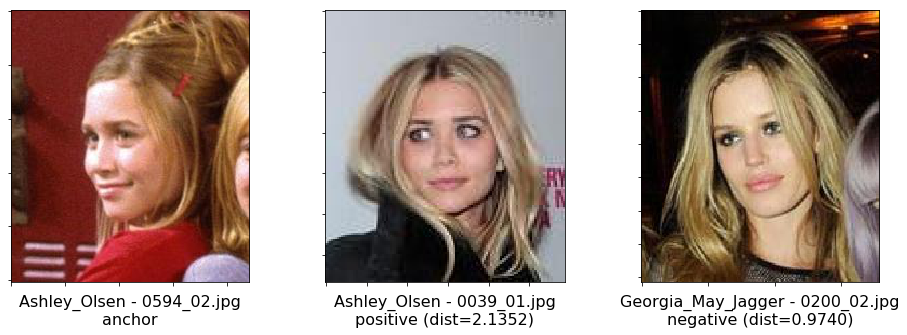

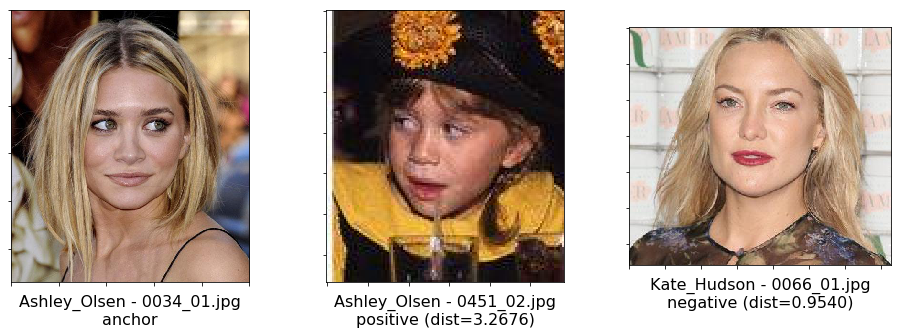

[Jessica_Hart] 75 / 100 correct triplets


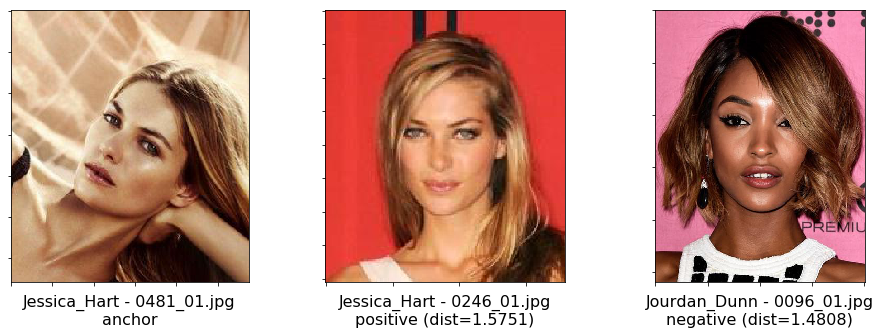

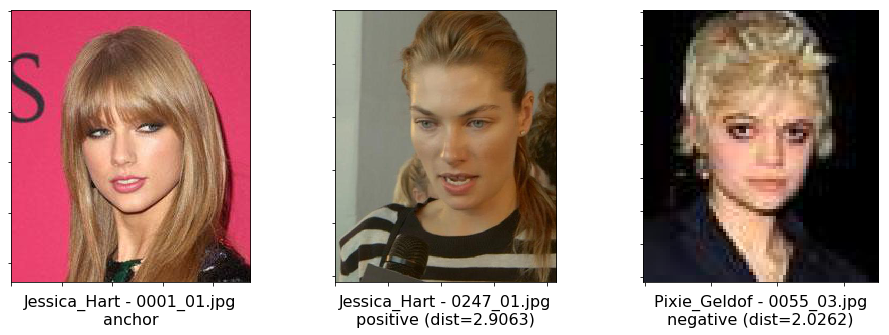

In [20]:
evaluate_model(model, './model_triplet.pth', triplet_datasets['test'], device, n_triplets = 10000, batch_size=64)

Arriba (en orden) se encuentran:

* la accuracy alcanzada en test (con 10000 triplets sampleados uniformemente) = 88.4%
* un histograma de accuracy por clase
* ejemplos de triplets para las 2 mejores clases y las 2 peores clases

Podemos observar que la accuracy 88.4% en test anda bien cerca del 89.8% alcanzado en validación. Esto parece confirmar que el modelo tiende a generalizar con una precisión ligeramente inferior a 90% (**en promedio**) con caras que nunca ha visto en entrenamiento. Mirando el histograma de accuracy, tenemos una visión más clara de la distribución. En el peor caso el modelo tiene una precisión de 74%, y en el mejor caso 100%. Entre esto dos valores parece haber una distribución normal. Mirando los ejemplos, notamos que en las 2 clases en que al modelo le va mejor los triplets son bien sencillos, mientras que en las 2 clases donde le va peor los triplets son más ambiguos (al menos desde mi punto de vista personal)

# Actividad 7

Otros casos de uso son [content-based image retrieval](https://en.wikipedia.org/wiki/Content-based_image_retrieval) (buscar imágenes similares visualmente a una imagen _query_, como en el paper [Learning Fine-grained Image Similarity with Deep Ranking
](https://www.cv-foundation.org/openaccess/content_cvpr_2014/html/Wang_Learning_Fine-grained_Image_2014_CVPR_paper.html)) y sistemas recomendadores de productos en base a similaridad visual (como en el paper [Deep Learning based Large Scale Visual Recommendation and Search for E-Commerce](https://arxiv.org/abs/1703.02344)), donde en ambos casos la idea es básicamente aprender un embedding que posicione las imágenes de tal manera que al ordenarlas por distancia respecto de una imagen _query_, estas queden ordenadas de mayor similaridad a menor similaridad (donde el concepto de "similaridad" depende del dominio particular)